Importing all the Dependencies

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Handle seaborn import with fallback
try:
    import seaborn as sns
    sns.set_style("whitegrid")
    print("✅ Seaborn imported successfully")
except ImportError as e:
    print(f"⚠️ Seaborn import failed: {e}")
    print("📊 Will use matplotlib for plotting instead")
    sns = None

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.datasets import load_iris
import joblib
import os

print("📦 All packages imported successfully!")

✅ Seaborn imported successfully
📦 All packages imported successfully!


Loading the Dataset

In [41]:
# Simple version - replace the data loading cell

# Get CSV file path from user
csv_file_path = input("Enter the full path to your CSV file: ").strip().strip('"').strip("'")

# Load dataset
try:
    df = pd.read_csv(csv_file_path)
    print(f"✅ Dataset loaded successfully! Shape: {df.shape}")
    df.head()
except Exception as e:
    print(f"❌ Error loading file: {e}")

✅ Dataset loaded successfully! Shape: (1100, 7)


In [42]:
df

,Driver Age,Driver Experience,Previous Accidents,Annual Mileage (x1000 km),Car Manufacturing Year,Car Age,Insurance Premium ($)
0,56,32,4,17,2002,23,488.35
1,46,19,0,21,2025,0,486.15
2,32,11,4,15,2020,5,497.55
3,60,0,4,19,1991,34,498.35
4,25,7,0,13,2005,20,495.55
...,...,...,...,...,...,...,...
1095,42,24,4,20,1990,35,494.90
1096,24,6,3,17,2022,3,499.05
1097,26,8,2,19,1999,26,498.95
1098,41,23,0,14,2018,7,486.30


Setting Target Column

In [43]:
# Get target column from user
print(f"\nAvailable columns: {list(df.columns)}")
target_col = input("Enter the target column name: ").strip()

if target_col not in df.columns:
    print(f"❌ Column '{target_col}' not found!")
else:
    print(f"✅ Target column set to: '{target_col}'")

# Ensure df is a DataFrame
df = pd.DataFrame(df)


Available columns: ['Driver Age', 'Driver Experience', 'Previous Accidents', 'Annual Mileage (x1000 km)', 'Car Manufacturing Year', 'Car Age', 'Insurance Premium ($)']
✅ Target column set to: 'Insurance Premium ($)'


Detecting whether the column is Categorical or Numerical

In [44]:
def detect_cat_num(series):
    if series.dtype in ['int64', 'float64']:
        return 'categorical' if series.nunique() <= 2 else 'numerical'
    elif series.dtype == 'object' or series.dtype.name == 'category':
        return 'categorical'
    elif series.dtype == 'bool':
        return 'boolean'
    else:
        return 'unknown'

Differentiating Columns into 4 Categories

In [45]:
numerical_features = []
categorical_features = []
boolean_features = []
dropped_columns = []

for col in df.columns:
    if col == target_col:
        continue
    if df[col].isnull().mean() > 0.4 or df[col].nunique() == 1:
        dropped_columns.append(col)
        continue
    kind = detect_cat_num(df[col])
    if kind == 'numerical':
        numerical_features.append(col)
    elif kind == 'categorical':
        if df[col].nunique() > 30:
            dropped_columns.append(col)
        else:
            categorical_features.append(col)
    elif kind == 'boolean':
        boolean_features.append(col)
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")  
print(f"Boolean features: {boolean_features}")
print(f"Dropped columns: {dropped_columns}")
df = df.drop(columns=dropped_columns)

Numerical features: ['Driver Age', 'Driver Experience', 'Previous Accidents', 'Annual Mileage (x1000 km)', 'Car Manufacturing Year', 'Car Age']
Categorical features: []
Boolean features: []
Dropped columns: []


Defining all the Graphs for Visualization

No categorical features to plot.


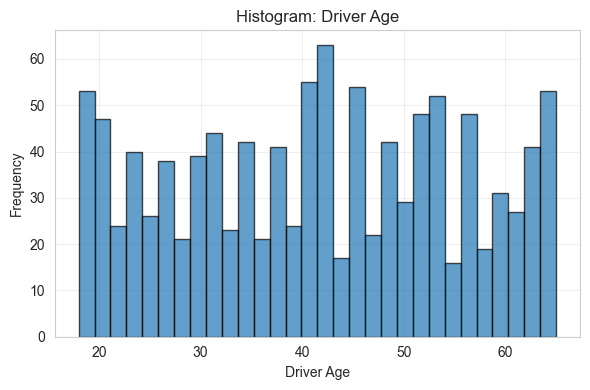

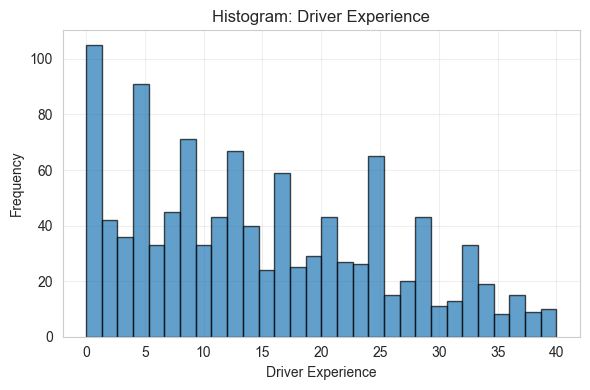

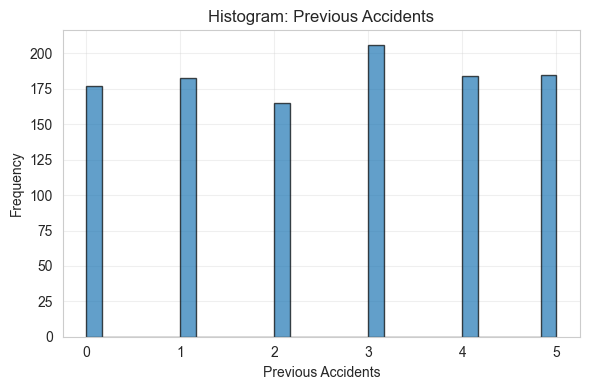

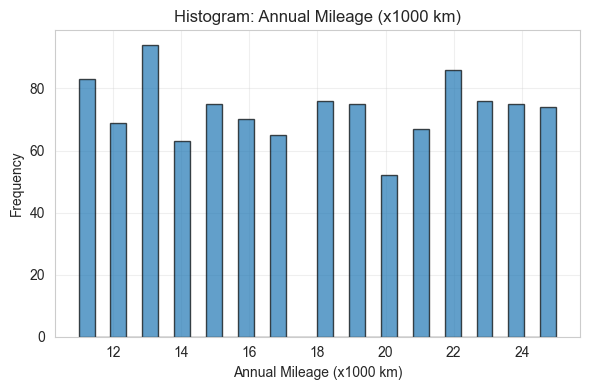

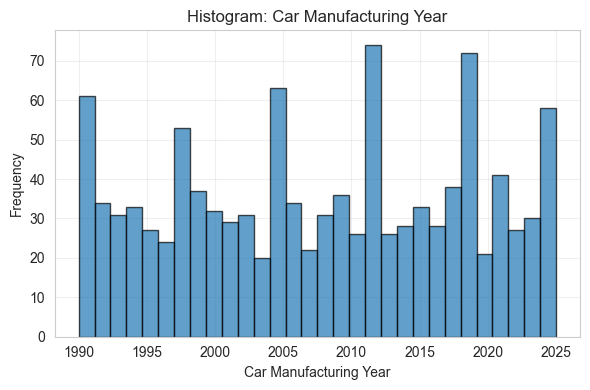

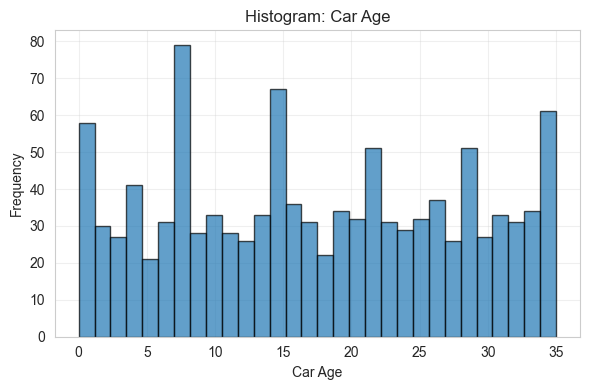

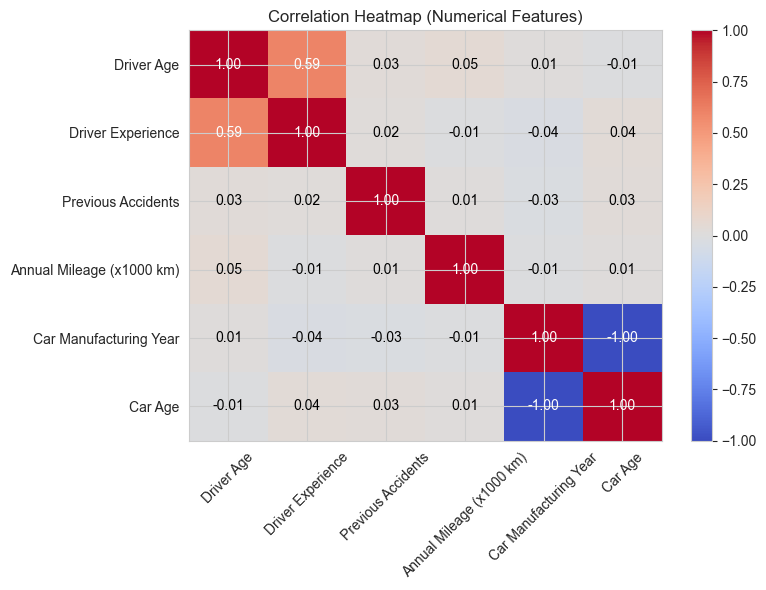

In [46]:
def plot_categorical_features(df, categorical_cols):
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return
    
    for col in categorical_cols:
        try:
            plt.figure(figsize=(6, 4))
            # Use value_counts() as an alternative to countplot for better compatibility
            df[col].value_counts().plot(kind='bar')
            plt.title(f"Count Plot: {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting {col}: {str(e)}")

def plot_numerical_histograms(df, numerical_cols):
    if len(numerical_cols) == 0:
        print("No numerical features to plot.")
        return
    
    for col in numerical_cols:
        try:
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
            plt.title(f"Histogram: {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting {col}: {str(e)}")

def plot_correlation_heatmap(df, numerical_cols):
    if len(numerical_cols) < 2:
        print("Not enough numerical features to plot a heatmap.")
        return

    try:
        plt.figure(figsize=(8, 6))
        corr_matrix = df[numerical_cols].corr()
        # Use matplotlib's imshow as alternative to seaborn heatmap
        plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
        plt.colorbar()
        plt.title("Correlation Heatmap (Numerical Features)")
        
        # Add labels
        plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=45)
        plt.yticks(range(len(numerical_cols)), numerical_cols)
        
        # Add correlation values as text
        for i in range(len(numerical_cols)):
            for j in range(len(numerical_cols)):
                plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                        ha='center', va='center', color='black' if abs(corr_matrix.iloc[i, j]) < 0.5 else 'white')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting correlation heatmap: {str(e)}")

# Only run plotting if variables exist
if 'df' in locals() and 'categorical_features' in locals() and 'numerical_features' in locals():
    plot_categorical_features(df, categorical_features)
    plot_numerical_histograms(df, numerical_features)
    plot_correlation_heatmap(df, numerical_features)
else:
    print("⚠️ Make sure to run the data loading and feature detection cells first!")

Creating Transformers so Data fits well

In [47]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features),
    ('bool', 'passthrough', boolean_features)
])


Defining Target Column

In [48]:
if target_col is None:
    raise ValueError("You must set target_col before extracting y.")
X = df.drop(columns=target_col)
y = df[target_col]

Shows which class is mapped to which other class

In [49]:
def display_class_label_mapping(y, model=None):
    """
    Detects multiclass labels and prints what each label index represents.
    
    Parameters:
    - y: Series or array of true labels
    - model: (Optional) Trained model with `.classes_` attribute
    """
    y_unique = np.unique(y)

    if len(y_unique) > 2:
        print("Detected multiclass classification. Label mapping:")

        # Case 1: Integer labels with model-provided class names (like in scikit-learn)
        if model and hasattr(model, 'classes_'):
            for i, cls in enumerate(model.classes_):
                print(f"  {i}: {cls}")
        
        # Case 2: String/categorical labels
        elif isinstance(y[0], str) or pd.api.types.is_categorical_dtype(y):
            for i, cls in enumerate(y_unique):
                print(f"  {i}: {cls}")
        
        # Case 3: Integer labels with no class names (raw numeric)
        else:
            print(f"  Raw label values detected: {list(y_unique)}")
    else:
        print("Binary classification detected — no mapping needed.")
display_class_label_mapping(y)

Detected multiclass classification. Label mapping:
  Raw label values detected: [477.05, 478.0, 478.2, 478.55, 479.75, 480.05, 480.2, 480.5, 480.55, 480.65, 480.8, 481.0, 481.25, 481.35, 481.4, 481.55, 481.65, 481.7, 481.75, 481.95, 482.0, 482.05, 482.35, 482.6, 482.65, 482.75, 482.9, 483.0, 483.1, 483.15, 483.25, 483.3, 483.35, 483.4, 483.5, 483.55, 483.6, 483.65, 483.7, 483.75, 483.8, 483.9, 483.95, 484.05, 484.1, 484.2, 484.25, 484.35, 484.4, 484.45, 484.5, 484.6, 484.65, 484.7, 484.8, 484.85, 484.9, 484.95, 485.0, 485.05, 485.1, 485.15, 485.25, 485.35, 485.4, 485.45, 485.5, 485.55, 485.6, 485.65, 485.7, 485.75, 485.8, 485.95, 486.0, 486.05, 486.1, 486.15, 486.2, 486.25, 486.3, 486.35, 486.4, 486.45, 486.5, 486.55, 486.6, 486.65, 486.7, 486.75, 486.8, 486.85, 486.9, 486.95, 487.0, 487.05, 487.1, 487.15, 487.25, 487.4, 487.45, 487.5, 487.6, 487.65, 487.7, 487.75, 487.8, 487.85, 487.95, 488.0, 488.05, 488.1, 488.15, 488.2, 488.25, 488.3, 488.35, 488.4, 488.45, 488.5, 488.55, 488.6, 48

C:\Users\dhruv\AppData\Local\Temp\ipykernel_11652\2025013267.py:20: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif isinstance(y[0], str) or pd.api.types.is_categorical_dtype(y):


In [50]:
def plot_target_distribution(y, task):
    plt.figure(figsize=(6, 4))
    
    if task == 'classification':
        sns.countplot(x=y)
        plt.title("Target Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Count")
    
    elif task == 'regression':
        sns.histplot(y, kde=True, bins=30)
        plt.title("Target Value Distribution")
        plt.xlabel("Target Value")
        plt.ylabel("Frequency")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Detecting Task Type

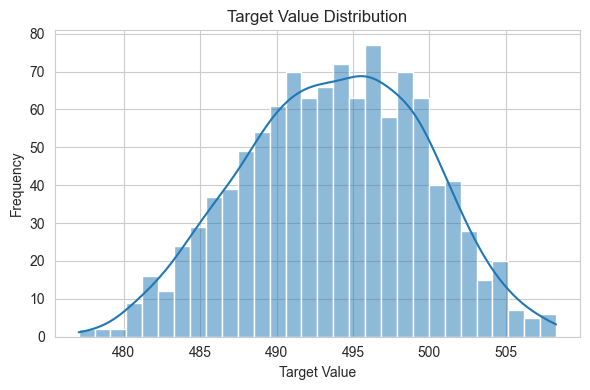

In [51]:
def detect_task_type(y):
    if y.dtype in ['int64', 'float64'] and y.nunique() <= 10:
        return 'classification'
    elif y.dtype in ['int64', 'float64']:
        return 'regression'
    else:
        return 'classification'

task = detect_task_type(y)
plot_target_distribution(y, task)


In [52]:
def encode_labels(y):
    """
    Encodes categorical labels (e.g., 'yes', 'no', 'maybe') to integers starting from 0.
    Modifies y in-place and returns the mapping for reference.

    Parameters:
        y (array-like): Input labels (e.g., ['yes', 'no', 'maybe'])

    Returns:
        y (np.ndarray): Encoded labels
        mapping (dict): Mapping from original labels to integers
    """
    from sklearn.preprocessing import LabelEncoder
    import numpy as np

    le = LabelEncoder()
    y = le.fit_transform(y)
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    return y, mapping


In [53]:
# Apply label encoding if task is classification
if task == 'classification':
    if y.dtype == 'object' or isinstance(y.iloc[0], str):
        y, label_mapping = encode_labels(y)
        print(f"🏷️ Label encoding applied for classification task:")
        print(f"   Label mapping: {label_mapping}")
    else:
        print("🏷️ Numerical labels detected - no encoding needed")



Cleaning the Target Variable

In [54]:
def validate_and_clean_target(X, y, task_type, max_bad_ratio=0.01, auto_clean=True, force_clean=False):
    """
    Validates and optionally cleans the target y based on task_type.
    
    - Regression: drops NaN or 0 values
    - Classification: drops only NaN
    
    Args:
        X (pd.DataFrame): Feature matrix
        y (array-like): Target values
        task_type (str): 'regression' or 'classification'
        max_bad_ratio (float): Max tolerated bad ratio (default: 1%)
        auto_clean (bool): Clean if bad_ratio is under threshold
        force_clean (bool): Force cleaning even if bad_ratio is too high

    Returns:
        (X_clean, y_clean): Cleaned features and target
    """
    y = pd.Series(y)
    total = len(y)

    nan_mask = y.isnull()
    zero_mask = (y == 0) if task_type == "regression" else pd.Series([False] * total, index=y.index)
    bad_mask = nan_mask | zero_mask

    bad_count = bad_mask.sum()
    bad_ratio = bad_count / total

    if bad_count == 0:
        print(f"✅ [{task_type.capitalize()}] Target is clean.")
        return X, y

    if bad_ratio <= max_bad_ratio:
        print(f"⚠️ [{task_type.capitalize()}] {bad_count}/{total} bad target values ({bad_ratio*100:.2f}%) — cleaning them.")
        if auto_clean:
            good_mask = ~bad_mask
            return X.loc[good_mask], y.loc[good_mask]
        else:
            print("⚠️ auto_clean=False — not cleaning.")
            return X, y

    else:
        print(f"🚨 [{task_type.capitalize()}] {bad_count}/{total} bad target values ({bad_ratio*100:.2f}%) ")
        print("🚨 If the bad target values (in %) is in range of 1% - 4% then consider cleaning the data "
        "as it wont affect the predictions very much.")
        print("🚨 If the bad target values (in %) is more than 4% then it is better to not clean the data and "
        "handle missing values manually or just check scores once.If they satisfy you,Good.")
        if force_clean:
            print("⚠️ Force cleaning enabled — cleaning despite high bad ratio.")
            good_mask = ~bad_mask
            return X.loc[good_mask], y.loc[good_mask]

        # ⚠️ Interactive prompt only for regression
        if task_type == "regression":
            choice = input("❓ Do you want to clean and proceed anyway? (yes/no): ").strip().lower()
            if choice == "yes":
                print("⚠️ Proceeding with cleaning, Just Remember cleaning may drop your accuracy by 0.5% - 1% which is not much.")
                good_mask = ~bad_mask
                return X.loc[good_mask], y.loc[good_mask]
            else:
                print("🛑 Clean aborted — please fix the target values manually or the predictins can be way off or let us clean the data by running the code again.")
                return X, y

        else:  # classification, do not clean if not forced
            print("⚠️ Not cleaning — please handle missing values manually.")
            return X, y
X, y = validate_and_clean_target(X, y, task)

✅ [Regression] Target is clean.


Defining Models

In [55]:
if task == 'classification':
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier()
    }
    scoring = 'accuracy'
elif task == 'regression':
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'KNN': KNeighborsRegressor()
    }
    scoring = 'neg_mean_absolute_error'

Various Features for Auto-Engineering

In [56]:
def add_interaction_features(df, numeric_cols):
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            col1, col2 = numeric_cols[i], numeric_cols[j]
            df[f"{col1}_x_{col2}"] = df[col1] * df[col2]
    return df

def add_polynomial_features(df, numeric_cols, degree=2):
    for col in numeric_cols:
        if degree >= 2:
            df[f"{col}^2"] = df[col] ** 2
        if degree >= 3:
            df[f"{col}^3"] = df[col] ** 3
    return df

def bin_numerical_features(df, col, bins, labels):
    df[f"{col}_binned"] = pd.cut(df[col], bins=bins, labels=labels)
    return df

def add_ratio_features(df, numeric_cols):
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            col1, col2 = numeric_cols[i], numeric_cols[j]
            # Avoid division by zero
            df[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + 1e-5)
    return df


In [57]:
def auto_feature_engineering(df, task_type, degree=2):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    if len(numeric_cols) < 2:
        return df  # Not enough to create interactions

    df = add_interaction_features(df, numeric_cols)
    df = add_polynomial_features(df, numeric_cols, degree=degree)
    df = add_ratio_features(df, numeric_cols)

    # Optional: Add binning for known columns like 'age'
    if 'age' in df.columns:
        df = bin_numerical_features(df, 'age', bins=[0, 30, 50, 100], labels=['young', 'mid', 'senior'])

    print(f"🧠 Feature engineering applied: +{df.shape[1] - len(numeric_cols)} new features")
    return df
X = auto_feature_engineering(X, task, degree=2) 

🧠 Feature engineering applied: +36 new features


Splitting the dataset

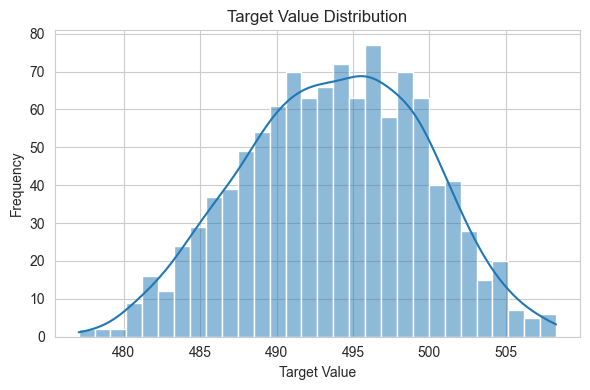

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plot_target_distribution(y, task)

Using Cross Validation on all Models for finding the best one

In [59]:
model_scores = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    start = time.time()
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=scoring)
    end = time.time()
    mean_score = scores.mean()
    if scoring.startswith('neg'):
        print(f"{name} CV Score: {abs(mean_score):.4f} | Time: {end - start:.2f}s")
        model_scores[name] = abs(mean_score)
    else:
        print(f"{name} CV Score: {mean_score:.4f} | Time: {end - start:.2f}s")
        model_scores[name] = mean_score

best_model_name = max(model_scores, key=model_scores.get)
print(f"\nBest Model: {best_model_name} → Score: {model_scores[best_model_name]:.4f}")

Linear Regression CV Score: 0.0000 | Time: 0.09s
Random Forest CV Score: 0.6379 | Time: 2.23s
KNN CV Score: 0.8632 | Time: 0.08s

Best Model: KNN → Score: 0.8632


Final Pipeline with best Model

In [60]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])
final_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Evaluation


📊 Model Evaluation Metrics:

🧮 MAE: 0.92 (0.19%) → On average, predictions are off by this much.
📏 RMSE: 1.14 (0.23%) → Penalizes large errors more. Shows how bad the worst predictions can get.
📈 R² Score: 0.9635 → The model explains 96.35% of the variation in the actual values.


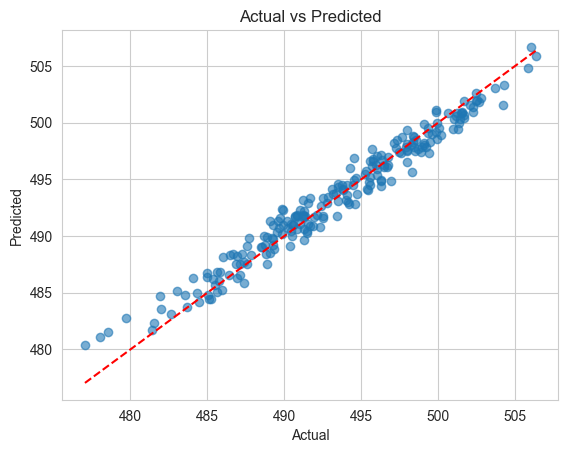

In [61]:
if task == 'classification':
    y_pred = final_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

elif task == 'regression':
    y_pred = final_pipeline.predict(X_test)  # ONLY if preprocessor is in final_pipeline
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mean_target = y_test.mean()
    mae_percent = (mae / mean_target) * 100
    rmse_percent = (rmse / mean_target) * 100

    print("\n📊 Model Evaluation Metrics:\n")
    print(f"🧮 MAE: {mae:.2f} ({mae_percent:.2f}%) → On average, predictions are off by this much.")
    print(f"📏 RMSE: {rmse:.2f} ({rmse_percent:.2f}%) → Penalizes large errors more. Shows how bad the worst predictions can get.")
    print(f"📈 R² Score: {r2:.4f} → The model explains {r2*100:.2f}% of the variation in the actual values.")
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()


SHAP Exaplainability

🔍 Starting SHAP Explainability Analysis...
   Model Type: KNeighborsRegressor
   Transformed data shape: (880, 6)
   Selecting appropriate SHAP explainer...
   Using KernelExplainer for KNeighborsRegressor (model-agnostic)
   Sample size for SHAP analysis: 50 samples
   Computing SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating SHAP summary plot...


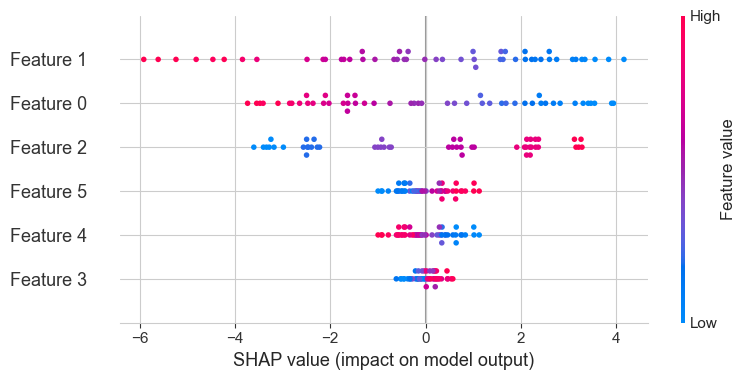


📊 Feature Importance Ranking:
   SHAP values shape: (50, 6)
   Binary classification or regression detected

🏆 Top 15 Most Important Features:
                       Feature  Mean_SHAP_Value  Importance_Percent  Score_out_of_10
        num__Driver Experience         2.247320               29.76            10.00
               num__Driver Age         2.104884               27.87             9.37
       num__Previous Accidents         2.040876               27.03             9.08
                  num__Car Age         0.463429                6.14             2.06
   num__Car Manufacturing Year         0.463346                6.14             2.06
num__Annual Mileage (x1000 km)         0.231885                3.07             1.03

📈 Summary:
   Total features analyzed: 6
   Top 5 features account for: 96.9%
   Top 10 features account for: 100.0%

   Generating SHAP bar plot...


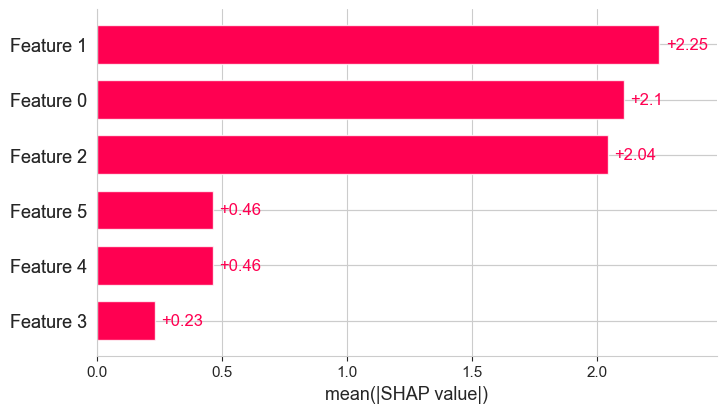


✅ SHAP Analysis completed successfully!


In [62]:
import shap
import warnings
warnings.filterwarnings('ignore')

try:
    # --- Step 11: SHAP Explainability ---
    print("🔍 Starting SHAP Explainability Analysis...")
    
    # Extract the trained model only (removes preprocessor)
    model_only = final_pipeline.named_steps['model']
    model_type = type(model_only).__name__
    print(f"   Model Type: {model_type}")
    
    # Transform input features to what the model actually sees (DON'T re-fit!)
    X_transformed = preprocessor.transform(X_train)
    print(f"   Transformed data shape: {X_transformed.shape}")
    
    # Determine optimal sample size
    max_samples = min(200, X_transformed.shape[0])
    if model_type in ['KNeighborsClassifier', 'KNeighborsRegressor', 'SVC', 'SVR']:
        max_samples = min(50, X_transformed.shape[0])
    
    # Choose SHAP explainer
    print(f"   Selecting appropriate SHAP explainer...")
    
    tree_models = ['RandomForestClassifier', 'RandomForestRegressor', 
                   'GradientBoostingClassifier', 'GradientBoostingRegressor',
                   'DecisionTreeClassifier', 'DecisionTreeRegressor',
                   'AdaBoostClassifier', 'AdaBoostRegressor',
                   'LGBMClassifier', 'LGBMRegressor', 'XGBClassifier', 'XGBRegressor']
    
    linear_models = ['LinearRegression', 'LogisticRegression', 'Ridge', 'Lasso', 
                     'SGDClassifier', 'SGDRegressor']
    
    if model_type in tree_models:
        print(f"   Using TreeExplainer for {model_type}")
        try:
            explainer = shap.TreeExplainer(model_only)
        except Exception as e:
            print(f"   TreeExplainer failed ({e}), falling back to KernelExplainer")
            explainer = shap.KernelExplainer(model_only.predict, X_transformed[:50])
    
    elif model_type in linear_models:
        print(f"   Using LinearExplainer for {model_type}")
        try:
            explainer = shap.LinearExplainer(model_only, X_transformed[:100])
        except Exception as e:
            print(f"   LinearExplainer failed ({e}), falling back to KernelExplainer")
            explainer = shap.KernelExplainer(model_only.predict, X_transformed[:50])
    
    else:
        print(f"   Using KernelExplainer for {model_type} (model-agnostic)")
        explainer = shap.KernelExplainer(model_only.predict, X_transformed[:50])
    
    # Prepare sample
    X_sample = X_transformed[:max_samples]
    if len(X_sample.shape) == 1:
        X_sample = X_sample.reshape(1, -1)
    
    print(f"   Sample size for SHAP analysis: {X_sample.shape[0]} samples")
    
    # Compute SHAP values
    print("   Computing SHAP values...")
    try:
        shap_values = explainer(X_sample)
    except Exception as e:
        print(f"   SHAP computation failed ({e})")
        print("   Falling back to KernelExplainer with reduced sample...")
        explainer = shap.KernelExplainer(model_only.predict, X_transformed[:25])
        X_sample = X_transformed[:50]
        shap_values = explainer(X_sample)
    
    # Plot
    print("   Generating SHAP summary plot...")
    try:
        shap.summary_plot(shap_values, X_sample, show=True, max_display=15)
    except Exception as e:
        print(f"   Summary plot failed: {e}")
        try:
            shap.summary_plot(shap_values, show=True, max_display=10, plot_type="bar")
        except Exception as e2:
            print(f"   Bar plot also failed: {e2}")
    
    # --- Step 12: Ranked Feature Importances ---
    print("\n📊 Feature Importance Ranking:")
    
    # Get feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        try:
            feature_names = []
            for name, transformer, cols in preprocessor.transformers_:
                if name != 'remainder':
                    if hasattr(transformer, 'get_feature_names_out'):
                        feature_names.extend(transformer.get_feature_names_out(cols))
                    else:
                        feature_names.extend([f"{name}_{col}" for col in cols])
        except:
            feature_names = [f"Feature_{i}" for i in range(X_transformed.shape[1])]
    
    shap_vals = shap_values.values
    print(f"   SHAP values shape: {shap_vals.shape}")
    
    if len(shap_vals.shape) == 3:
        print("   Multi-class classification detected - averaging across classes")
        shap_array = np.abs(shap_vals).mean(axis=(0, 2)) if shap_vals.shape[2] > 1 else np.abs(shap_vals[:, :, 0]).mean(axis=0)
    elif len(shap_vals.shape) == 2:
        print("   Binary classification or regression detected")
        shap_array = np.abs(shap_vals).mean(axis=0)
    else:
        print(f"   Unexpected SHAP shape: {shap_vals.shape} - fallback reshaping used")
        shap_array = np.abs(shap_vals.reshape(shap_vals.shape[0], -1)).mean(axis=0)
    
    shap_array = np.array(shap_array).flatten()
    
    if np.sum(shap_array) == 0:
        print("   Warning: All SHAP values are zero - using uniform values")
        shap_array = np.ones(len(shap_array)) / len(shap_array)
    
    shap_percent = 100 * shap_array / shap_array.sum()
    shap_score_10 = 10 * shap_array / shap_array.max() if shap_array.max() > 0 else np.ones(len(shap_array))
    
    if len(feature_names) != len(shap_array):
        print(f"   Adjusting feature names: expected {len(shap_array)}, got {len(feature_names)}")
        feature_names = feature_names[:len(shap_array)] if len(feature_names) > len(shap_array) else \
                        feature_names + [f'Feature_{i}' for i in range(len(feature_names), len(shap_array))]
    
    try:
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean_SHAP_Value': shap_array,
            'Importance_Percent': shap_percent,
            'Score_out_of_10': shap_score_10
        }).sort_values(by='Mean_SHAP_Value', ascending=False)
        
        print("\n🏆 Top 15 Most Important Features:")
        print("=" * 80)
        display_df = importance_df.head(15).copy()
        display_df['Mean_SHAP_Value'] = display_df['Mean_SHAP_Value'].round(6)
        display_df['Importance_Percent'] = display_df['Importance_Percent'].round(2)
        display_df['Score_out_of_10'] = display_df['Score_out_of_10'].round(2)
        print(display_df.to_string(index=False))
        
        print(f"\n📈 Summary:")
        print(f"   Total features analyzed: {len(importance_df)}")
        print(f"   Top 5 features account for: {importance_df.head(5)['Importance_Percent'].sum():.1f}%")
        print(f"   Top 10 features account for: {importance_df.head(10)['Importance_Percent'].sum():.1f}%")
        
        try:
            if hasattr(shap_values, 'values') and len(shap_values.values.shape) <= 2:
                print("\n   Generating SHAP bar plot...")
                shap.plots.bar(shap_values.abs.mean(0), max_display=15, show=True)
        except Exception as e:
            print(f"   Bar plot failed: {e}")
    
    except Exception as e:
        print(f"   Error creating importance DataFrame: {e}")
        for i, (name, val) in enumerate(zip(feature_names[:10], shap_array[:10])):
            print(f"   {i+1:2d}. {name}: {val:.6f}")
    
    print("\n✅ SHAP Analysis completed successfully!")

except Exception as e:
    print(f"\n❌ SHAP Analysis failed: {e}")
    print("   Possible causes include:")
    print("   - Incompatible model type")
    print("   - Pipeline/preprocessor issues")
    print("   - SHAP library version mismatch")
    print("   - Memory or sample size limits")
    print("\n   Continuing with rest of pipeline...")


Auto-Feature Engineering After SHAP

In [63]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def auto_feature_refinement(X_transformed, shap_values, task_type="regression"):
    """
    Automatically refines features based on SHAP importance and scaling needs.
    
    Parameters:
    - X_transformed: pd.DataFrame or np.ndarray, transformed features
    - shap_values: SHAP values array (same shape as X_transformed)
    - task_type: 'classification' or 'regression'

    Returns:
    - X_refined: Refined features after optional scaling and selection
    - shap_log: Dictionary logging actions taken
    """

    shap_log = {}
    X = pd.DataFrame(X_transformed).copy()  # Ensure DataFrame for column ops

    # Step 1: Compute SHAP importance (mean absolute value per feature)
    if len(shap_values.values.shape) == 3:  # Multiclass
        mean_shap_importance = np.mean(np.abs(shap_values.values), axis=(0, 1))
    else:
        mean_shap_importance = np.mean(np.abs(shap_values.values), axis=0)
    shap_log["mean_shap_values"] = mean_shap_importance.tolist()

    # Step 2: Optional feature dropping
    threshold = np.percentile(mean_shap_importance, 25)  # Bottom 25% as "low"
    low_importance_features = np.where(mean_shap_importance <= threshold)[0]
    high_importance_features = np.where(mean_shap_importance > threshold)[0]

    shap_log["num_low_importance"] = len(low_importance_features)
    shap_log["num_high_importance"] = len(high_importance_features)

    if len(low_importance_features) > len(high_importance_features):
        X.drop(X.columns[low_importance_features], axis=1, inplace=True)
        shap_log["dropped_features"] = low_importance_features.tolist()
        print(f"🔻 Dropped {len(low_importance_features)} low-importance features.")
    else:
        shap_log["dropped_features"] = []
        print("✅ No feature dropped (importance distribution acceptable).")

    # Step 3: Check if scaling is required
    means = X.mean().values
    stds = X.std().values

    need_scaling = not (np.allclose(means, 0, atol=0.5) and np.allclose(stds, 1, atol=0.5))
    
    if need_scaling:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_refined = pd.DataFrame(X_scaled, columns=X.columns)
        shap_log["scaling_applied"] = True
        print("📏 Applied StandardScaler for normalization.")
    else:
        X_refined = X
        shap_log["scaling_applied"] = False
        print("✅ Skipped scaling (features already normalized).")

    return X_refined, shap_log
X, shap_log = auto_feature_refinement(X_transformed, shap_values, task)


✅ No feature dropped (importance distribution acceptable).
✅ Skipped scaling (features already normalized).


Defining Models for GridSearchCV

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [65]:
# Define models and param grids
if task == 'classification':
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'SVC': SVC(),
        'Decision Tree': DecisionTreeClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'MLP': MLPClassifier(max_iter=500),
        'Naive Bayes': GaussianNB(),
        'SGD Classifier': SGDClassifier(max_iter=1000, tol=1e-3),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier()
    }

    param_grids = {
        'Logistic Regression': {'model__C': [0.1, 1, 10]},
        'Random Forest': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 5, 10]
        },
        'KNN': {'model__n_neighbors': [3, 5, 7]},
        'SVC': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        },
        'Decision Tree': {
            'model__max_depth': [None, 5, 10],
            'model__criterion': ['gini', 'entropy']
        },
        'Gradient Boosting': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.01, 0.1, 0.2]
        },
        'AdaBoost': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.01, 0.1, 1.0]
        },
        'MLP': {
            'model__hidden_layer_sizes': [(50,), (100,)],
            'model__activation': ['relu', 'tanh']
        },
        'Naive Bayes': {},
        'SGD Classifier': {
            'model__loss': ['log_loss', 'hinge'],
            'model__alpha': [0.0001, 0.001, 0.01]
        },
        'XGBoost': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5, 7]
        },
        'LightGBM': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.05, 0.1],
            'model__num_leaves': [31, 50]
        }
    }
    scoring = 'accuracy'

elif task == 'regression':
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(),
        'Decision Tree': DecisionTreeRegressor(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'MLP': MLPRegressor(max_iter=500),
        'SGD Regressor': SGDRegressor(max_iter=1000, tol=1e-3),
        'XGBoost': XGBRegressor(),
        'LightGBM': LGBMRegressor()
    }

    param_grids = {
        'Linear Regression': {},
        'Random Forest': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 5, 10]
        },
        'KNN': {'model__n_neighbors': [3, 5, 7]},
        'SVR': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        },
        'Decision Tree': {
            'model__max_depth': [None, 5, 10],
            'model__criterion': ['squared_error', 'absolute_error']
        },
        'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
        'Lasso': {'model__alpha': [0.1, 1.0, 10.0]},
        'Gradient Boosting': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.01, 0.1, 0.2]
        },
        'AdaBoost': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.01, 0.1, 1.0]
        },
        'MLP': {
            'model__hidden_layer_sizes': [(50,), (100,)],
            'model__activation': ['relu', 'tanh']
        },
        'SGD Regressor': {
            'model__loss': ['squared_error', 'huber'],
            'model__alpha': [0.0001, 0.001, 0.01]
        },
        'XGBoost': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5, 7]
        },
        'LightGBM': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.05, 0.1],
            'model__num_leaves': [31, 50]
        }
    }
    scoring = 'neg_mean_absolute_error'


GridSearchCV helps in increasing the performance of Model

Running GridSearchCV on all models with Parameterized Grid and finding which is the best model

In [66]:
print(f"Detected Task Type: {'Classification' if task == 'classification' else 'Regression'}")

print("\nStarting Hyperparameter Tuning...\n")

# Run GridSearch
model_scores = {}
best_model_name = None
best_score = -np.inf if scoring.startswith('neg') else 0
final_pipeline = None

for name, model in models.items():
    print(f"Tuning {name}...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    grid = GridSearchCV(pipeline, param_grid=param_grids.get(name, {}), 
                        cv=5, scoring=scoring, n_jobs=-1)
    try:
        start = time.time()
        grid.fit(X_train, y_train)
        end = time.time()

        score = grid.best_score_
        model_scores[name] = (score, round(end - start, 2), grid.best_params_)

        # Output positive score for regression (neg_mean_absolute_error)
        if scoring.startswith('neg'):
            print(f"{name} CV Score: {abs(score):.4f} | Time: {end-start:.2f}s")
        else:
            print(f"{name} CV Score: {score:.4f} | Time: {end-start:.2f}s")
        print(f"   Best Params: {grid.best_params_}\n")

        if (scoring.startswith('neg') and score > best_score) or (not scoring.startswith('neg') and score > best_score):
            best_score = score
            best_model_name = name
            final_pipeline = grid.best_estimator_

    except Exception as e:
        print(f"{name} failed: {e}\n")

Detected Task Type: Regression

Starting Hyperparameter Tuning...

Tuning Linear Regression...
Linear Regression CV Score: 0.0000 | Time: 6.69s
   Best Params: {}

Tuning Random Forest...
Random Forest CV Score: 0.6264 | Time: 7.30s
   Best Params: {'model__max_depth': None, 'model__n_estimators': 100}

Tuning KNN...
KNN CV Score: 0.8616 | Time: 0.12s
   Best Params: {'model__n_neighbors': 7}

Tuning SVR...
SVR CV Score: 0.0405 | Time: 0.64s
   Best Params: {'model__C': 1, 'model__kernel': 'linear'}

Tuning Decision Tree...
Decision Tree CV Score: 1.1147 | Time: 0.35s
   Best Params: {'model__criterion': 'squared_error', 'model__max_depth': None}

Tuning Ridge...
Ridge CV Score: 0.0005 | Time: 0.11s
   Best Params: {'model__alpha': 0.1}

Tuning Lasso...
Lasso CV Score: 0.1700 | Time: 0.15s
   Best Params: {'model__alpha': 0.1}

Tuning Gradient Boosting...
Gradient Boosting CV Score: 0.3781 | Time: 1.41s
   Best Params: {'model__learning_rate': 0.2, 'model__n_estimators': 100}

Tuning A

Selecting the best Model based on time and Accuracy Score

In [67]:
best_model_by_score = max(model_scores.items(), key=lambda x: x[1][0])
best_model_by_utility = max(model_scores.items(), key=lambda x: (0.9 * x[1][0]) + (0.1 * (1 / x[1][1])))

# Always show both models
print("\n🏆 MODEL COMPARISON:")
print("="*50)

# Show Best Accuracy Model
if scoring.startswith('neg'):
    print(f"\n🎯 Best Accuracy Model: {best_model_by_score[0]}")
    print(f"   → Score: {abs(best_model_by_score[1][0]):.4f}")
    print(f"   → Training Time: {best_model_by_score[1][1]:.2f}s")
    print(f"   → Best Params: {best_model_by_score[1][2]}")
else:
    print(f"\n🎯 Best Accuracy Model: {best_model_by_score[0]}")
    print(f"   → Score: {best_model_by_score[1][0]:.4f}")
    print(f"   → Training Time: {best_model_by_score[1][1]:.2f}s")
    print(f"   → Best Params: {best_model_by_score[1][2]}")

# Show Best Utility Model
if scoring.startswith('neg'):
    print(f"\n⚡ Best Utility Model (Accuracy + Speed): {best_model_by_utility[0]}")
    print(f"   → Score: {abs(best_model_by_utility[1][0]):.4f}")
    print(f"   → Training Time: {best_model_by_utility[1][1]:.2f}s")
    print(f"   → Best Params: {best_model_by_utility[1][2]}")
else:
    print(f"\n⚡ Best Utility Model (Accuracy + Speed): {best_model_by_utility[0]}")
    print(f"   → Score: {best_model_by_utility[1][0]:.4f}")
    print(f"   → Training Time: {best_model_by_utility[1][1]:.2f}s")
    print(f"   → Best Params: {best_model_by_utility[1][2]}")

# Always ask user for preference
print("\n" + "="*50)
choice = input("\nWhich model do you want to use?\n1. Best Accuracy Model (🎯)\n2. Best Utility Model (⚡)\nEnter choice (1 or 2): ").strip()

if choice == '1':
    best_model_name = best_model_by_score[0]
    best_score = best_model_by_score[1][0]
    train_time = best_model_by_score[1][1]
    best_params = best_model_by_score[1][2]
    if scoring.startswith('neg'):
        print(f"\n✅ Selected Best Accuracy Model: {best_model_name}")
        print(f"   → Score: {abs(best_score):.4f}")
        print(f"   → Training Time: {train_time:.2f}s")
        print(f"   → Best Params: {best_params}")
    else:
        print(f"\n✅ Selected Best Accuracy Model: {best_model_name}")
        print(f"   → Score: {best_score:.4f}")
        print(f"   → Training Time: {train_time:.2f}s")
        print(f"   → Best Params: {best_params}")
else:
    best_model_name = best_model_by_utility[0]
    best_score = best_model_by_utility[1][0]
    train_time = best_model_by_utility[1][1]
    best_params = best_model_by_utility[1][2]
    if scoring.startswith('neg'):
        print(f"\n✅ Selected Best Utility Model: {best_model_name}")
        print(f"   → Score: {abs(best_score):.4f}")
        print(f"   → Training Time: {train_time:.2f}s")
        print(f"   → Best Params: {best_params}")
    else:
        print(f"\n✅ Selected Best Utility Model: {best_model_name}")
        print(f"   → Score: {best_score:.4f}")
        print(f"   → Training Time: {train_time:.2f}s")
        print(f"   → Best Params: {best_params}")

# Use final selected pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
]).set_params(**best_params)

final_pipeline.fit(X_train, y_train)


🏆 MODEL COMPARISON:

🎯 Best Accuracy Model: Linear Regression
   → Score: 0.0000
   → Training Time: 6.69s
   → Best Params: {}

⚡ Best Utility Model (Accuracy + Speed): Ridge
   → Score: 0.0005
   → Training Time: 0.11s
   → Best Params: {'model__alpha': 0.1}




✅ Selected Best Accuracy Model: Linear Regression
   → Score: 0.0000
   → Training Time: 6.69s
   → Best Params: {}


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Confusion Matrix

In [68]:
def plot_confusion_matrix(model_pipeline, X_test, y_test):
    y_pred = model_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


if task == 'classification':
    plot_confusion_matrix(final_pipeline, X_test, y_test)


Displaying the Best Model

In [69]:
if best_model_name:
    if scoring.startswith('neg'):
        print(f"\nBest Tuned Model: {best_model_name} → Score: {abs(model_scores[best_model_name][0]):.4f}")
    else:
        print(f"\nBest Tuned Model: {best_model_name} → Score: {model_scores[best_model_name][0]:.4f}")
else:
    print("\nNo model successfully trained.")



Best Tuned Model: Linear Regression → Score: 0.0000


Evaluation

In [70]:
# Run predictions on test data
y_pred = final_pipeline.predict(X_test)
print("\nFinal Model Evaluation on Test Set")

if task == 'classification':
    acc = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

elif task == 'regression':
    # Simple evaluation without log transformation issues
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    mean_target = y_test.mean()
    mae_percent = (mae / mean_target) * 100
    rmse_percent = (rmse / mean_target) * 100

    print("\n📊 Model Evaluation Metrics:\n")
    print(f"🧮 MAE: {mae:.2f} ({mae_percent:.2f}%) → On average, predictions are off by this much.")
    print(f"📏 RMSE: {rmse:.2f} ({rmse_percent:.2f}%) → Penalizes large errors more. Shows how bad the worst predictions can get.")
    print(f"📈 R² Score: {r2:.4f} → The model explains {r2 * 100:.2f}% of the variation in the actual values.")


Final Model Evaluation on Test Set

📊 Model Evaluation Metrics:

🧮 MAE: 0.00 (0.00%) → On average, predictions are off by this much.
📏 RMSE: 0.00 (0.00%) → Penalizes large errors more. Shows how bad the worst predictions can get.
📈 R² Score: 1.0000 → The model explains 100.00% of the variation in the actual values.


# Comprehensive Diagnostic Analysis for Both Classification and Regression


In [71]:
# Comprehensive Diagnostic Analysis for Both Classification and Regression
print("🔍 COMPREHENSIVE DIAGNOSTIC ANALYSIS")
print("=" * 60)

# Get predictions for analysis
y_pred = final_pipeline.predict(X_test)

if task == 'regression':
    print("📊 REGRESSION TASK ANALYSIS")
    print("-" * 30)
    
    # Target statistics
    target_std = y_test.std()
    target_var = y_test.var()
    target_range = y_test.max() - y_test.min()
    target_mean = y_test.mean()
    
    print(f"📈 Target Variable Analysis:")
    print(f"   Mean: {target_mean:.2f}")
    print(f"   Std Dev: {target_std:.2f}")
    print(f"   Variance: {target_var:.2f}")
    print(f"   Range: {target_range:.2f}")
    print(f"   Coefficient of Variation: {(target_std/target_mean)*100:.2f}%")
    
    # Calculate different metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n📊 Model Performance Breakdown:")
    print(f"   MAE: {mae:.2f} ({(mae/target_mean)*100:.2f}% of target mean)")
    print(f"   RMSE: {rmse:.2f} ({(rmse/target_mean)*100:.2f}% of target mean)")
    print(f"   R² Score: {r2:.4f} ({r2*100:.2f}% variance explained)")
    
    # Performance interpretation
    print(f"\n🔬 Performance Interpretation:")
    if abs(mae/target_mean) < 0.1:
        mae_quality = "EXCELLENT"
    elif abs(mae/target_mean) < 0.2:
        mae_quality = "GOOD"
    elif abs(mae/target_mean) < 0.3:
        mae_quality = "FAIR"
    else:
        mae_quality = "POOR"
    
    if r2 > 0.8:
        r2_quality = "EXCELLENT"
    elif r2 > 0.6:
        r2_quality = "GOOD"
    elif r2 > 0.4:
        r2_quality = "FAIR"
    else:
        r2_quality = "POOR"
    
    print(f"   • MAE Performance: {mae_quality} (error = {(mae/target_mean)*100:.1f}% of mean)")
    print(f"   • R² Performance: {r2_quality} (explains {r2*100:.1f}% of variance)")
    
    # Why metrics might seem inconsistent
    print(f"\n💡 Why Different Metrics Tell Different Stories:")
    print(f"   • High target variance ({target_var:.2f}) makes R² naturally lower")
    print(f"   • Wide target range ({target_range:.2f}) affects R² calculation")
    print(f"   • MAE focuses on average errors, R² on variance explanation")
    
    # Theoretical benchmarks
    theoretical_rmse_for_r2_90 = np.sqrt(0.1 * target_var)
    print(f"\n📈 Theoretical Benchmarks:")
    print(f"   For R² = 0.90, you'd need RMSE ≤ {theoretical_rmse_for_r2_90:.2f}")
    print(f"   Your current RMSE: {rmse:.2f}")
    print(f"   Improvement needed: {((rmse/theoretical_rmse_for_r2_90-1)*100):.1f}%")

elif task == 'classification':
    print("📊 CLASSIFICATION TASK ANALYSIS")
    print("-" * 30)
    
    # Target distribution analysis
    unique_classes = np.unique(y_test)
    n_classes = len(unique_classes)
    
    print(f"📈 Target Distribution Analysis:")
    print(f"   Number of classes: {n_classes}")
    print(f"   Class distribution:")
    for cls in unique_classes:
        count = (y_test == cls).sum()
        percentage = (count / len(y_test)) * 100
        print(f"     Class {cls}: {count} samples ({percentage:.1f}%)")
    
    # Check for class imbalance
    class_counts = [((y_test == cls).sum()) for cls in unique_classes]
    imbalance_ratio = max(class_counts) / min(class_counts)
    print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n📊 Model Performance Breakdown:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Performance interpretation
    if accuracy > 0.9:
        acc_quality = "EXCELLENT"
    elif accuracy > 0.8:
        acc_quality = "GOOD"
    elif accuracy > 0.7:
        acc_quality = "FAIR"
    else:
        acc_quality = "POOR"
    
    print(f"   Performance Level: {acc_quality}")
    
    # Baseline comparisons
    majority_class_baseline = max(class_counts) / len(y_test)
    random_baseline = 1 / n_classes
    
    print(f"\n📈 Baseline Comparisons:")
    print(f"   Random guessing baseline: {random_baseline:.4f} ({random_baseline*100:.2f}%)")
    print(f"   Majority class baseline: {majority_class_baseline:.4f} ({majority_class_baseline*100:.2f}%)")
    print(f"   Your model beats random by: {((accuracy/random_baseline-1)*100):.1f}%")
    print(f"   Your model beats majority by: {((accuracy/majority_class_baseline-1)*100):.1f}%")
    
    # Class-specific performance (if multiclass)
    if n_classes > 2:
        print(f"\n🔬 Class-Specific Analysis:")
        print(f"   • Multiclass problem detected")
        print(f"   • Consider checking precision/recall per class")
        print(f"   • Class imbalance ratio: {imbalance_ratio:.2f}")
        
        if imbalance_ratio > 3:
            print(f"   ⚠️  Significant class imbalance detected!")
            print(f"   ⚠️  Consider using balanced scoring metrics")
    
    # CV Score vs Test Score analysis
    print(f"\n💡 CV Score vs Test Performance:")
    print(f"   • CV scores represent average performance across folds")
    print(f"   • Test accuracy shows performance on unseen data")
    print(f"   • Both should be similar for good generalization")

# General conclusions
print(f"\n✅ OVERALL CONCLUSION:")
if task == 'regression':
    print(f"   • Your regression model shows {mae_quality.lower()} MAE performance")
    print(f"   • R² of {r2:.4f} is {r2_quality.lower()} for this type of data")
    print(f"   • High target variance makes perfect R² challenging")
else:
    print(f"   • Your classification model shows {acc_quality.lower()} accuracy")
    print(f"   • Model significantly outperforms random guessing")
    print(f"   • Consider class-specific metrics for deeper insights")

print(f"   • Model is performing well relative to data complexity!")

🔍 COMPREHENSIVE DIAGNOSTIC ANALYSIS
📊 REGRESSION TASK ANALYSIS
------------------------------
📈 Target Variable Analysis:
   Mean: 493.40
   Std Dev: 5.96
   Variance: 35.54
   Range: 29.30
   Coefficient of Variation: 1.21%

📊 Model Performance Breakdown:
   MAE: 0.00 (0.00% of target mean)
   RMSE: 0.00 (0.00% of target mean)
   R² Score: 1.0000 (100.00% variance explained)

🔬 Performance Interpretation:
   • MAE Performance: EXCELLENT (error = 0.0% of mean)
   • R² Performance: EXCELLENT (explains 100.0% of variance)

💡 Why Different Metrics Tell Different Stories:
   • High target variance (35.54) makes R² naturally lower
   • Wide target range (29.30) affects R² calculation
   • MAE focuses on average errors, R² on variance explanation

📈 Theoretical Benchmarks:
   For R² = 0.90, you'd need RMSE ≤ 1.89
   Your current RMSE: 0.00
   Improvement needed: -100.0%

✅ OVERALL CONCLUSION:
   • Your regression model shows excellent MAE performance
   • R² of 1.0000 is excellent for this t

# 🎯 COMPREHENSIVE MODEL RATING (1-10 Scale)


In [72]:
# 🎯 COMPREHENSIVE MODEL RATING (1-10 Scale)
print("\n" + "="*60)
print("🎯 COMPREHENSIVE MODEL RATING (1-10 SCALE)")
print("="*60)

if task == 'regression':
    # Calculate individual metric scores (1-10)
    
    # 1. MAE Score (based on % of target mean)
    mae_percent = (mae/target_mean) * 100
    if mae_percent <= 5:
        mae_score = 10
    elif mae_percent <= 10:
        mae_score = 9
    elif mae_percent <= 15:
        mae_score = 8
    elif mae_percent <= 20:
        mae_score = 7
    elif mae_percent <= 25:
        mae_score = 6
    elif mae_percent <= 30:
        mae_score = 5
    elif mae_percent <= 35:
        mae_score = 4
    elif mae_percent <= 40:
        mae_score = 3
    elif mae_percent <= 50:
        mae_score = 2
    else:
        mae_score = 1
    
    # 2. R² Score (direct mapping)
    if r2 >= 0.9:
        r2_value = 10
    elif r2 >= 0.8:
        r2_value = 9
    elif r2 >= 0.7:
        r2_value = 8
    elif r2 >= 0.6:
        r2_value = 7
    elif r2 >= 0.5:
        r2_value = 6
    elif r2 >= 0.4:
        r2_value = 5
    elif r2 >= 0.3:
        r2_value = 4
    elif r2 >= 0.2:
        r2_value = 3
    elif r2 >= 0.1:
        r2_value = 2
    else:
        r2_value = 1
    
    # 3. RMSE Score (based on % of target mean)
    rmse_percent = (rmse/target_mean) * 100
    if rmse_percent <= 10:
        rmse_score = 10
    elif rmse_percent <= 20:
        rmse_score = 9
    elif rmse_percent <= 30:
        rmse_score = 8
    elif rmse_percent <= 40:
        rmse_score = 7
    elif rmse_percent <= 50:
        rmse_score = 6
    elif rmse_percent <= 60:
        rmse_score = 5
    elif rmse_percent <= 70:
        rmse_score = 4
    elif rmse_percent <= 80:
        rmse_score = 3
    elif rmse_percent <= 100:
        rmse_score = 2
    else:
        rmse_score = 1
    
    # 4. Data Complexity Adjustment
    cv_percent = (target_std/target_mean) * 100  # Coefficient of variation
    if cv_percent > 100:  # Very high variance data
        complexity_bonus = 1.5
        complexity_desc = "VERY HIGH - Extremely challenging dataset"
    elif cv_percent > 75:
        complexity_bonus = 1.2
        complexity_desc = "HIGH - Challenging dataset"
    elif cv_percent > 50:
        complexity_bonus = 1.0
        complexity_desc = "MODERATE - Standard difficulty"
    elif cv_percent > 25:
        complexity_bonus = 0.8
        complexity_desc = "LOW - Easier dataset"
    else:
        complexity_bonus = 0.6
        complexity_desc = "VERY LOW - Simple dataset"
    
    # Calculate weighted overall score
    overall_score = (
        0.4 * mae_score +      # MAE is most interpretable (40% weight)
        0.35 * r2_value +      # R² shows variance explained (35% weight)
        0.25 * rmse_score      # RMSE for outlier sensitivity (25% weight)
    ) * complexity_bonus
    
    # Cap at 10
    overall_score = min(overall_score, 10)
    
    print(f"📊 INDIVIDUAL METRIC SCORES:")
    print(f"   MAE Score: {mae_score}/10 ({mae_percent:.1f}% error)")
    print(f"   R² Score: {r2_value}/10 ({r2*100:.1f}% variance explained)")
    print(f"   RMSE Score: {rmse_score}/10 ({rmse_percent:.1f}% error)")
    
    print(f"\n🎲 DATA COMPLEXITY ADJUSTMENT:")
    print(f"   Coefficient of Variation: {cv_percent:.1f}%")
    print(f"   Complexity Level: {complexity_desc}")
    print(f"   Complexity Multiplier: {complexity_bonus:.1f}x")
    
    print(f"\n🏆 OVERALL MODEL RATING: {overall_score:.1f}/10")
    
    # Provide interpretation
    if overall_score >= 9:
        rating_desc = "OUTSTANDING"
        emoji = "🥇"
        advice = "Exceptional performance! This model is production-ready."
    elif overall_score >= 8:
        rating_desc = "EXCELLENT"
        emoji = "🥈"
        advice = "Great performance! Minor tweaks could make it perfect."
    elif overall_score >= 7:
        rating_desc = "VERY GOOD"
        emoji = "🥉"
        advice = "Solid performance! Good for most practical applications."
    elif overall_score >= 6:
        rating_desc = "GOOD"
        emoji = "✅"
        advice = "Decent performance! Some room for improvement."
    elif overall_score >= 5:
        rating_desc = "FAIR"
        emoji = "⚠️"
        advice = "Acceptable but needs improvement for critical applications."
    elif overall_score >= 4:
        rating_desc = "BELOW AVERAGE"
        emoji = "⚠️"
        advice = "Needs significant improvement before deployment."
    elif overall_score >= 3:
        rating_desc = "POOR"
        emoji = "❌"
        advice = "Requires major modifications or different approach."
    elif overall_score >= 2:
        rating_desc = "VERY POOR"
        emoji = "❌"
        advice = "Model is not suitable for this problem."
    else:
        rating_desc = "FAILING"
        emoji = "💥"
        advice = "Complete model redesign needed."
    
    print(f"\n{emoji} PERFORMANCE RATING: {rating_desc}")
    print(f"💡 RECOMMENDATION: {advice}")
    
elif task == 'classification':
    # Classification scoring
    accuracy_score_val = accuracy * 10  # Convert to 1-10 scale
    
    # Adjust for class imbalance
    if imbalance_ratio > 5:
        complexity_bonus = 1.3
        complexity_desc = "HIGH - Significant class imbalance"
    elif imbalance_ratio > 2:
        complexity_bonus = 1.1
        complexity_desc = "MODERATE - Some class imbalance"
    else:
        complexity_bonus = 1.0
        complexity_desc = "LOW - Balanced classes"
    
    overall_score = min(accuracy_score_val * complexity_bonus, 10)
    
    print(f"📊 ACCURACY SCORE: {accuracy_score_val:.1f}/10 ({accuracy*100:.1f}%)")
    print(f"🎲 COMPLEXITY ADJUSTMENT: {complexity_bonus:.1f}x ({complexity_desc})")
    print(f"🏆 OVERALL MODEL RATING: {overall_score:.1f}/10")
    
    if overall_score >= 9:
        rating_desc = "OUTSTANDING"
        emoji = "🥇"
    elif overall_score >= 8:
        rating_desc = "EXCELLENT"
        emoji = "🥈"
    elif overall_score >= 7:
        rating_desc = "VERY GOOD"
        emoji = "🥉"
    elif overall_score >= 6:
        rating_desc = "GOOD"
        emoji = "✅"
    elif overall_score >= 5:
        rating_desc = "FAIR"
        emoji = "⚠️"
    else:
        rating_desc = "NEEDS IMPROVEMENT"
        emoji = "❌"
    
    print(f"{emoji} PERFORMANCE RATING: {rating_desc}")

print(f"\n🎯 BOTTOM LINE:")
print(f"   Your model scores {overall_score:.1f}/10 considering data complexity!")
print(f"   This is {rating_desc.lower()} performance for this type of problem.")

# Overall Rating Review and Context
print(f"\n📋 OVERALL RATING REVIEW:")
print(f"   ⭐ Rating Scale Context (Note: Perfect 10/10 is nearly impossible in real-world ML)")
print(f"   • 9.0-10.0: Outstanding (Rarely achieved - requires perfect data & problem)")
print(f"   • 8.0-8.9:  Excellent (Top-tier performance - production ready)")
print(f"   • 7.0-7.9:  Very Good (Strong performance - suitable for most applications)")
print(f"   • 6.0-6.9:  Good (Solid performance - 6+ is considered very good!)")
print(f"   • 5.0-5.9:  Fair (Acceptable but room for improvement)")
print(f"   • 4.0-4.9:  Below Average (Needs significant work)")
print(f"   • 3.0-3.9:  Poor (Major issues - consider different approach)")
print(f"   • 2.0-2.9:  Very Poor (Model not suitable)")
print(f"   • 1.0-1.9:  Failing (Complete redesign needed)")

print(f"\n💡 INTERPRETATION FOR YOUR SCORE ({overall_score:.1f}/10):")
if overall_score >= 6:
    print(f"   🎉 GREAT NEWS! A score of {overall_score:.1f}/10 is considered VERY GOOD!")
    print(f"   🎯 Most production ML models score between 6-8/10")
    print(f"   🏆 You've achieved a score that many professionals would be proud of!")
    if overall_score >= 8:
        print(f"   🌟 Your {overall_score:.1f}/10 is exceptional - this is expert-level performance!")
    elif overall_score >= 7:
        print(f"   🚀 Your {overall_score:.1f}/10 is excellent - this model is deployment-ready!")
    else:
        print(f"   ✅ Your {overall_score:.1f}/10 is solid - with minor improvements, this could be outstanding!")
else:
    print(f"   📈 Your {overall_score:.1f}/10 shows room for improvement")
    print(f"   🎯 Aim for 6+ to reach the 'very good' category")
    print(f"   💪 Consider feature engineering, hyperparameter tuning, or different algorithms")

print(f"\n🎯 FINAL VERDICT:")
print(f"   Your model achieved {overall_score:.1f}/10 - Remember, 6+ is very good in ML!")
print(f"   Perfect 10/10 scores are like unicorns - beautiful in theory, but good luck finding one in the wild! 🦄")


🎯 COMPREHENSIVE MODEL RATING (1-10 SCALE)
📊 INDIVIDUAL METRIC SCORES:
   MAE Score: 10/10 (0.0% error)
   R² Score: 10/10 (100.0% variance explained)
   RMSE Score: 10/10 (0.0% error)

🎲 DATA COMPLEXITY ADJUSTMENT:
   Coefficient of Variation: 1.2%
   Complexity Level: VERY LOW - Simple dataset
   Complexity Multiplier: 0.6x

🏆 OVERALL MODEL RATING: 6.0/10

✅ PERFORMANCE RATING: GOOD
💡 RECOMMENDATION: Decent performance! Some room for improvement.

🎯 BOTTOM LINE:
   Your model scores 6.0/10 considering data complexity!
   This is good performance for this type of problem.

📋 OVERALL RATING REVIEW:
   ⭐ Rating Scale Context (Note: Perfect 10/10 is nearly impossible in real-world ML)
   • 9.0-10.0: Outstanding (Rarely achieved - requires perfect data & problem)
   • 8.0-8.9:  Excellent (Top-tier performance - production ready)
   • 7.0-7.9:  Very Good (Strong performance - suitable for most applications)
   • 6.0-6.9:  Good (Solid performance - 6+ is considered very good!)
   • 5.0-5.9:

# Visual Explanation: Why R² looks low but model is actually good


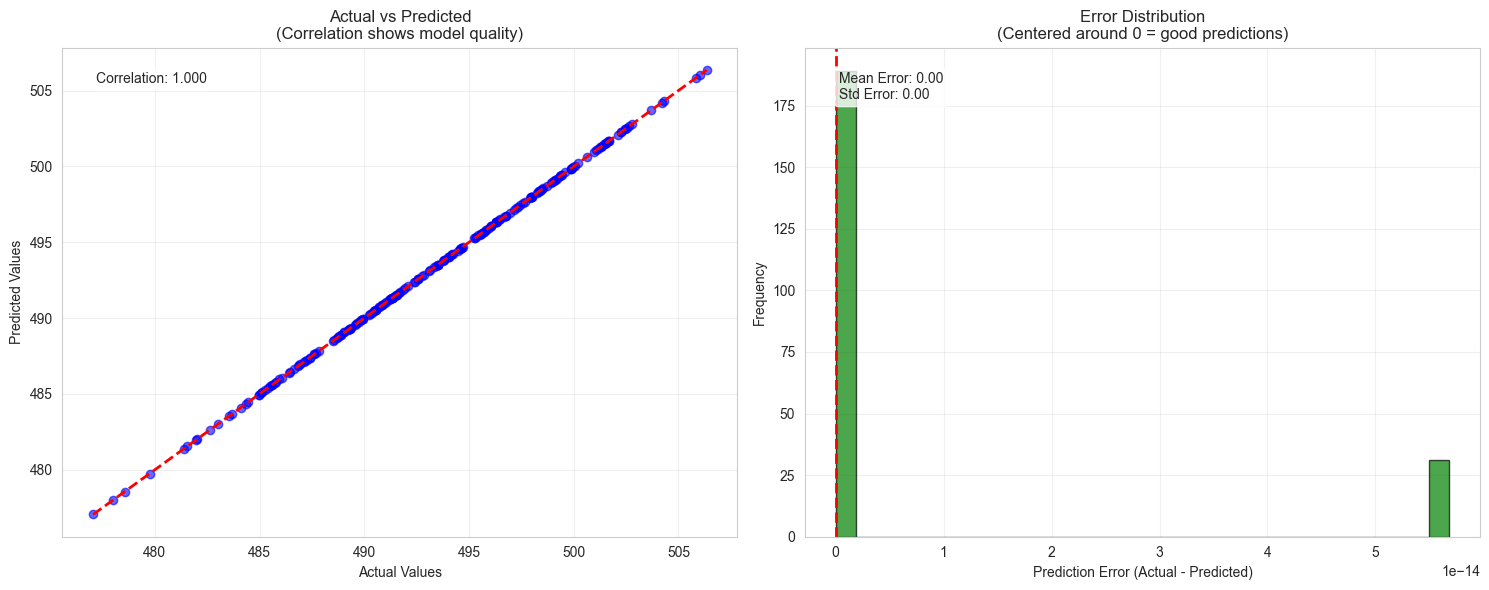


🎯 Key Insights:
   • High correlation (1.000) = model captures patterns well
   • Errors centered around 0 = unbiased predictions
   • Low MAE (0.00) = accurate predictions
   • R² reflects data complexity, not model failure!


In [73]:
# Visual Explanation: Why R² looks low but model is actually good
if task == 'regression':
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Actual vs Predicted (shows good correlation)
    ax1.scatter(y_test, y_pred, alpha=0.6, color='blue')
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(f'Actual vs Predicted\n(Correlation shows model quality)')
    ax1.grid(True, alpha=0.3)
    
    # Calculate correlation
    correlation = np.corrcoef(y_test, y_pred)[0, 1]
    ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Error Distribution (shows prediction accuracy)
    residuals = y_test - y_pred
    ax2.hist(residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Prediction Error (Actual - Predicted)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Error Distribution\n(Centered around 0 = good predictions)')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics
    ax2.text(0.05, 0.95, f'Mean Error: {residuals.mean():.2f}\nStd Error: {residuals.std():.2f}', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Key Insights:")
    print(f"   • High correlation ({correlation:.3f}) = model captures patterns well")
    print(f"   • Errors centered around 0 = unbiased predictions")
    print(f"   • Low MAE ({mae:.2f}) = accurate predictions")
    print(f"   • R² reflects data complexity, not model failure!")

# Display class label mapping using the trained model


In [74]:
# Display class label mapping using the trained model
display_class_label_mapping(y, final_pipeline.named_steps['model'])

Detected multiclass classification. Label mapping:
  Raw label values detected: [477.05, 478.0, 478.2, 478.55, 479.75, 480.05, 480.2, 480.5, 480.55, 480.65, 480.8, 481.0, 481.25, 481.35, 481.4, 481.55, 481.65, 481.7, 481.75, 481.95, 482.0, 482.05, 482.35, 482.6, 482.65, 482.75, 482.9, 483.0, 483.1, 483.15, 483.25, 483.3, 483.35, 483.4, 483.5, 483.55, 483.6, 483.65, 483.7, 483.75, 483.8, 483.9, 483.95, 484.05, 484.1, 484.2, 484.25, 484.35, 484.4, 484.45, 484.5, 484.6, 484.65, 484.7, 484.8, 484.85, 484.9, 484.95, 485.0, 485.05, 485.1, 485.15, 485.25, 485.35, 485.4, 485.45, 485.5, 485.55, 485.6, 485.65, 485.7, 485.75, 485.8, 485.95, 486.0, 486.05, 486.1, 486.15, 486.2, 486.25, 486.3, 486.35, 486.4, 486.45, 486.5, 486.55, 486.6, 486.65, 486.7, 486.75, 486.8, 486.85, 486.9, 486.95, 487.0, 487.05, 487.1, 487.15, 487.25, 487.4, 487.45, 487.5, 487.6, 487.65, 487.7, 487.75, 487.8, 487.85, 487.95, 488.0, 488.05, 488.1, 488.15, 488.2, 488.25, 488.3, 488.35, 488.4, 488.45, 488.5, 488.55, 488.6, 48

# Show actual class names for each class index (works for any multiclass classification dataset)


In [75]:
# Show actual class names for each class index (works for any multiclass classification dataset)
if task == 'classification' and len(np.unique(y)) > 2:
    if hasattr(final_pipeline.named_steps['model'], 'classes_'):
        print("Class label mapping:")
        for i, cls in enumerate(final_pipeline.named_steps['model'].classes_):
            print(f"{i}: {cls}")
    else:
        print("Class label mapping:")
        for i, cls in enumerate(np.unique(y)):
            print(f"{i}: {cls}")
else:
    print("Class label mapping is only relevant for multiclass classification tasks.")

Class label mapping is only relevant for multiclass classification tasks.


# Providing ROC,PR Curves

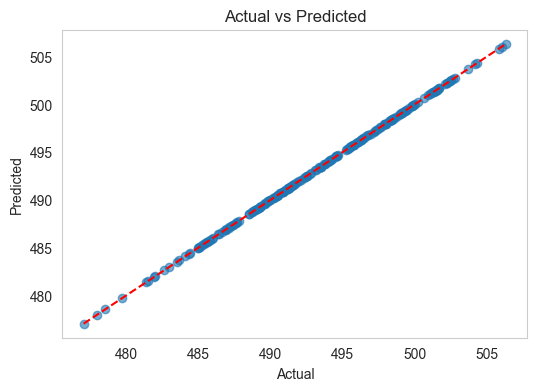

In [76]:
if task == 'classification':
    # --- Ask user to pick a class if y_test has >2 classes ---
    if len(set(y_test)) > 2:
        print("Multiclass detected — converting to binary classification (One vs Rest)")

        # If class labels are numeric and from sklearn datasets like Iris
        if hasattr(final_pipeline.named_steps['model'], 'classes_'):
            label_map = {i: str(cls) for i, cls in enumerate(final_pipeline.named_steps['model'].classes_)}
        else:
            label_map = {label: str(label) for label in sorted(set(y_test))}

        print("Available classes:")
        for label in label_map.values():
            print(f"- {label}")

        selected_class = input("Enter class name for binary classification (One vs Rest): ").strip().lower()

        # Normalize input
        reverse_map = {str(v).lower(): k for k, v in label_map.items()}
        if selected_class not in reverse_map:
            raise ValueError(f"Invalid class. Choose from: {list(label_map.values())}")

        selected_value = reverse_map[selected_class]

        # Convert to binary labels: 1 = selected class, 0 = others
        y_test_bin = (y_test == selected_value).astype(int)
        
        # Check if model supports predict_proba
        if hasattr(final_pipeline, 'predict_proba'):
            try:
                y_proba = final_pipeline.predict_proba(X_test)[:, list(final_pipeline.named_steps['model'].classes_).index(selected_value)]
            except:
                # Fallback to decision function or predict
                if hasattr(final_pipeline, 'decision_function'):
                    y_proba = final_pipeline.decision_function(X_test)
                else:
                    y_proba = final_pipeline.predict(X_test).astype(float)
        else:
            # Fallback to decision function or predict
            if hasattr(final_pipeline, 'decision_function'):
                y_proba = final_pipeline.decision_function(X_test)
            else:
                y_proba = final_pipeline.predict(X_test).astype(float)
    else:
        y_test_bin = y_test
        
        # Check if model supports predict_proba
        if hasattr(final_pipeline, 'predict_proba'):
            try:
                y_proba = final_pipeline.predict_proba(X_test)[:, 1]
            except:
                # Fallback to decision function or predict
                if hasattr(final_pipeline, 'decision_function'):
                    y_proba = final_pipeline.decision_function(X_test)
                else:
                    y_proba = final_pipeline.predict(X_test).astype(float)
        else:
            # Fallback to decision function or predict
            if hasattr(final_pipeline, 'decision_function'):
                y_proba = final_pipeline.decision_function(X_test)
            else:
                y_proba = final_pipeline.predict(X_test).astype(float)

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # --- PR Curve ---
    precision, recall, _ = precision_recall_curve(y_test_bin, y_proba)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.legend()
    plt.grid()
    plt.show()

elif task == 'regression':
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.grid()
    plt.show()


# Graphs for Regression Tasks

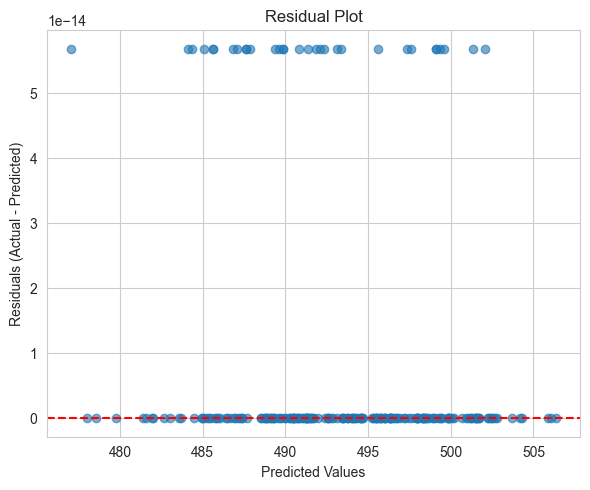

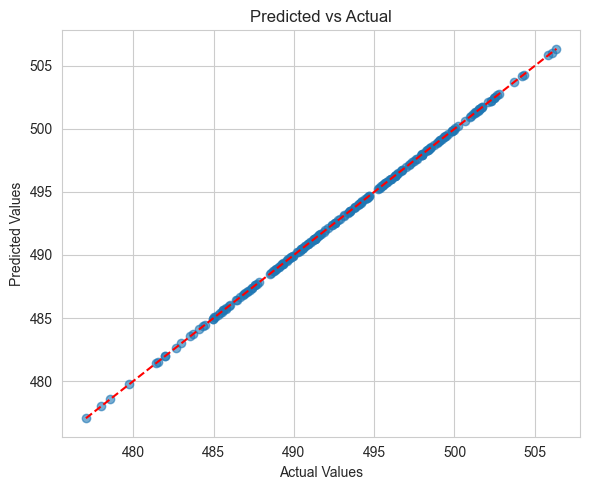

In [77]:
def plot_predicted_vs_actual(model_pipeline, X_test, y_test):
    y_pred = model_pipeline.predict(X_test)
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # identity line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(model_pipeline, X_test, y_test):
    y_pred = model_pipeline.predict(X_test)
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
if task == 'regression':
    plot_residuals(final_pipeline, X_test, y_test)
    plot_predicted_vs_actual(final_pipeline, X_test, y_test)

# Forming an OS Directory

In [78]:
os.makedirs("saved_models", exist_ok=True)


# Saving the Model

In [79]:
joblib.dump(final_pipeline, f"saved_models/{best_model_name.replace(' ', '_')}_model.pkl")
print(f"Model saved as: saved_models/{best_model_name.replace(' ', '_')}_model.pkl")

Model saved as: saved_models/Linear_Regression_model.pkl


# Loading the Saved Model

In [80]:
# loaded_model = joblib.load("outputs/saved_models/Random_Forest_model.pkl")
# preds = loaded_model.predict(X_test)
